In [2]:
import sys

sys.path.append("C:/Users/junsu/volatility_arbitrage")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt

from volatility_arbitrage.pricing_model.heston_model import generate_heston_processes
from volatility_arbitrage.pricing_model.interface import (
    HestonParams,
    MarketModel,
    StrategyPnl,
)
from volatility_arbitrage.pricing_model.weighted_variance_swap import (
    SkewSwap,
    StrategyPnlCalculator,
)
from volatility_arbitrage.strategy.evaluation import (
    plot_pnl_distribution,
    plot_pnl_of_path,
    plot_vega_hedge_performance_of_path,
)

# Model Setup

In [4]:
BDAYS = 252

length = BDAYS
time_delta = 1 / length
realized_vol = 0.16
num_path = 10_000

heston_model = HestonParams(kappa=5, mean_of_var=realized_vol**2, vol_of_var=0.5, rho=-0.4)
market_model = MarketModel(
    imp_model=heston_model,
    real_model=heston_model,
    rho_spot_imp_var=-0.4,
    rho_real_var_imp_var=1 - 1e-13,
)

np.random.seed(0)
normal_var = np.random.normal(size=(2, length, num_path))
lr, real_var = generate_heston_processes(
    var_0=realized_vol**2,
    model_params=heston_model,
    normal_var_1=normal_var[0],
    normal_var_2=normal_var[1],
    num_path=num_path,
    length=length,
    time_delta=time_delta,
)

f = 100 * np.exp(np.cumsum(lr, axis=0))

# Trading Foward Skewness Swap Rolling Everyday

In [5]:
target_dte = np.arange(1, BDAYS + 1, 1)

skew_swap = SkewSwap(market_model=market_model)
skew_swap_pnl_per_dte: dict[int, StrategyPnlCalculator] = {}

for dte in target_dte:
    tau_0 = np.full_like(real_var[1:], dte / BDAYS)
    tau_1 = np.full_like(real_var[1:], dte / BDAYS - time_delta)

    pnl_calculator = skew_swap.get_pnl_calculator(
        f_0=f[:-1],
        f_t=f[1:],
        real_var_0=real_var[:-1],
        imp_var_0=real_var[:-1],
        tau_0=tau_0,
        imp_var_t=real_var[1:],
        tau_t=tau_1,
    )
    skew_swap_pnl_per_dte[dte] = pnl_calculator

## Continuous Long 1 Month / 1 Day Skew Swap Strategy

In [6]:
cont_long_strategy = np.full_like(real_var[:-1], 10000)
day_skew_swap_pnl = skew_swap_pnl_per_dte[1].get_strategy_pnl(cont_long_strategy)
cont_long_pnl: StrategyPnl = (
    skew_swap_pnl_per_dte[21].get_strategy_pnl(cont_long_strategy) - day_skew_swap_pnl
)

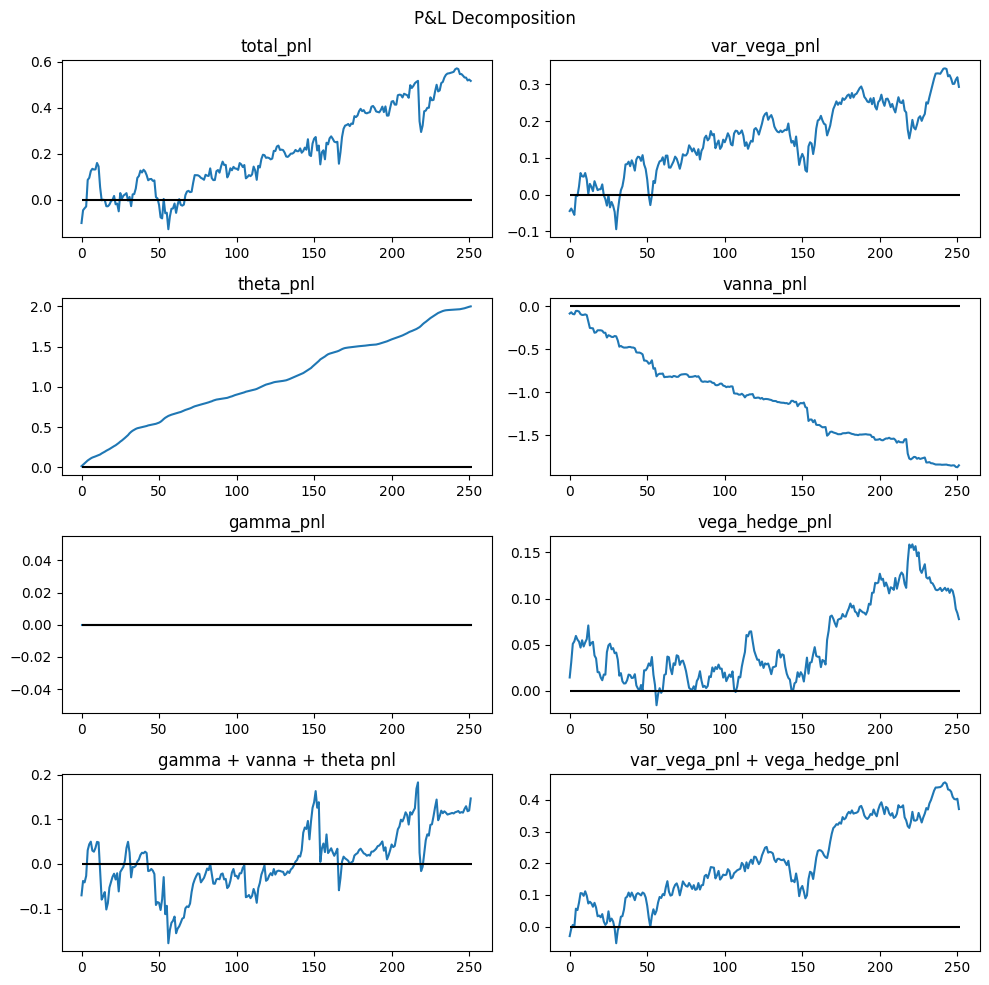

In [7]:
plot_pnl_of_path(cont_long_pnl, 0)

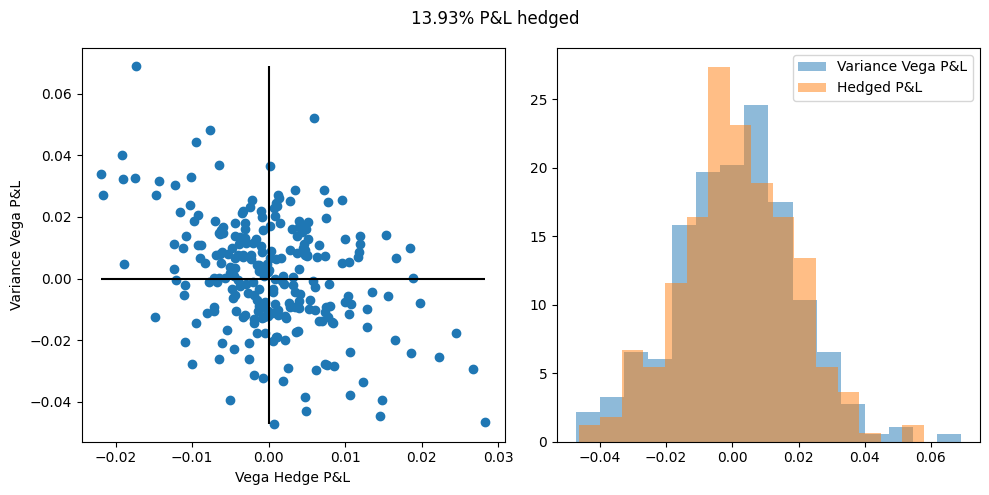

In [8]:
plot_vega_hedge_performance_of_path(cont_long_pnl, 0)

- Theoretically, $\underbrace{16\%}_{\rho^2}$ of Vega P&L should be hedged in expectation.

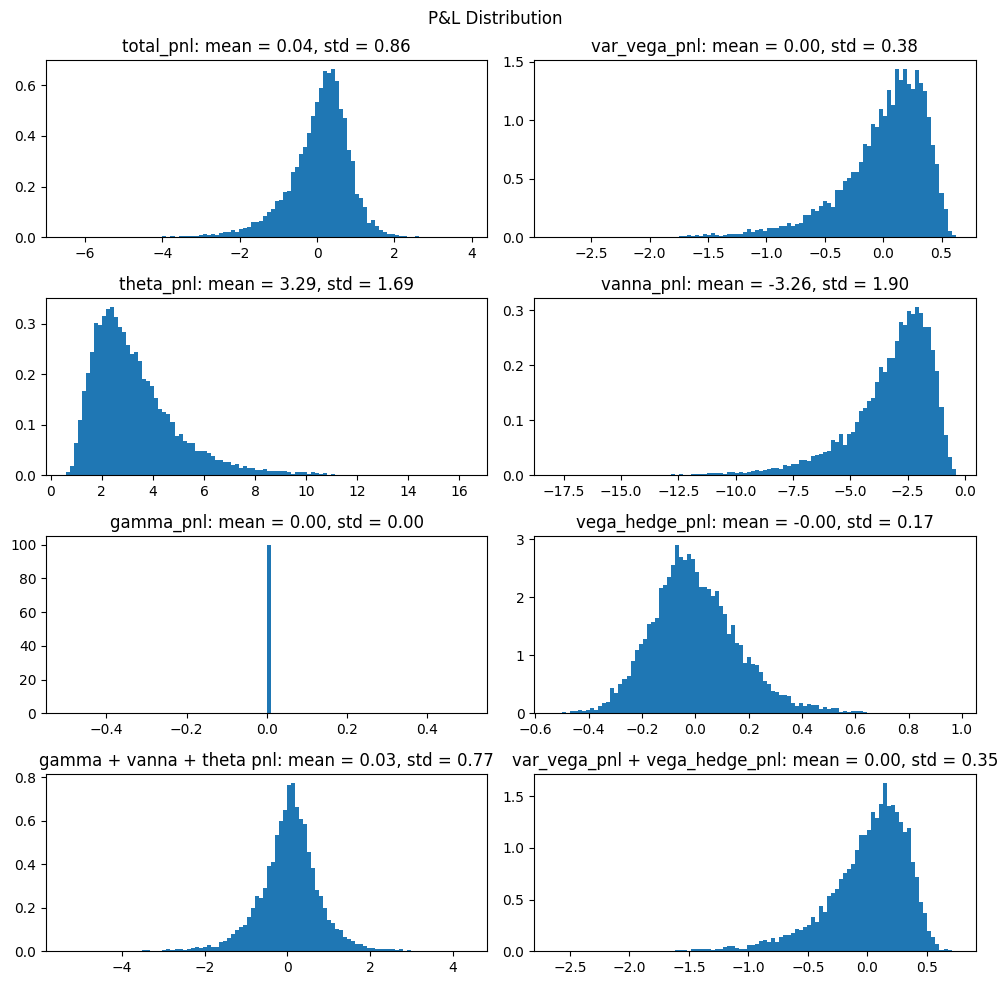

In [9]:
plot_pnl_distribution(cont_long_pnl)

- Total P&L is not mean zero.
- I guess this is because the Heston model simulation is not exact and the number of path is not enough.

## Ex Post Sharpe Ratio per DTE

In [10]:
ann_sharpe_per_dte: dict[int, npt.NDArray[np.float64]] = {}

for dte, pnl_calculator in skew_swap_pnl_per_dte.items():
    if dte != 1:
        cont_long_pnl: StrategyPnl = (
            pnl_calculator.get_strategy_pnl(cont_long_strategy) - day_skew_swap_pnl
        )
        ann_sharpe_per_dte[dte] = cont_long_pnl.total_pnl.mean(axis=0) / (
            cont_long_pnl.total_pnl.std(axis=0) * np.sqrt(time_delta)
        )

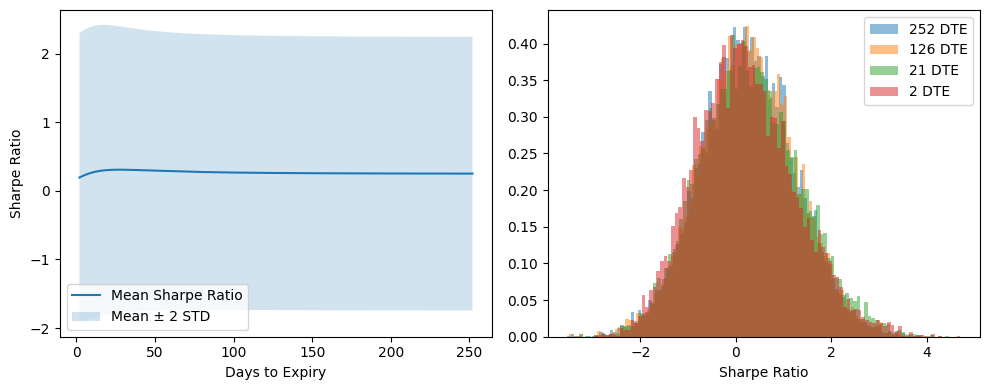

In [11]:
means = [np.mean(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]
stds = [np.std(ann_sharpe) for ann_sharpe in ann_sharpe_per_dte.values()]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(target_dte[1:], means, label="Mean Sharpe Ratio")
ax[0].fill_between(
    target_dte[1:],
    np.array(means) - 2 * np.array(stds),
    np.array(means) + 2 * np.array(stds),
    alpha=0.2,
    label="Mean ± 2 STD",
)
ax[0].set_xlabel("Days to Expiry")
ax[0].set_ylabel("Sharpe Ratio")
ax[0].legend()

for dte in [BDAYS, 21 * 6, 21, 2]:
    ax[1].hist(
        ann_sharpe_per_dte[dte],
        density=True,
        bins=int(np.sqrt(len(ann_sharpe_per_dte[dte]))),
        label=f"{dte} DTE",
        alpha=0.5,
    )
ax[1].set_xlabel("Sharpe Ratio")
ax[1].legend()

fig.tight_layout()
plt.show()

- As expected, Ex Post Sharpe ratio is near zero. 